# Using Deep Learning to Predict Numerical Values using Antibody Thermostability as an Example

### Questions:

- How may we use a deep learning predictor to predict numerical values

- How can we measure the accuracy of the deep learning predictor?


### Objectives:
    
- Use encoded antibody protein sequences to train a deep learning predictor to predict antibody thermostability.

- Measure the accuracy of the deep learning model.

- Improve the accuracy of the deep learning model.

### Introduction 

In this example we will look at antibody sequences and their thermostabilities to demonstrate how how deep learning algorithms may calculate a numerical score rather than a classification. Antibodies are made up of two heavy and two light chains, however, the functional antigen-binding domains are Fv fragments at each fork of the "Y" shape. These Fv fragments are where the VH domain of a heavy chain and VL domain of a light chain interact and so much study has been dedicated to these regions. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. This knowledge was rare in the past and came from studying individual antibodies, however, the advent of B-cell encapsulation and Next Generation Sequencing now allowed researchers to sequence a repertoire of paired antibodies (Rajan *et al.*, 2018).


In order to train a model to predict the \Delta$ G of Unfolding of antibodies, we have to encode our sequences into numerical values that capture meaningful representations of the strings. We will be doing this using the Propythia module (Sequeira *et al.*, 2022) which calculates physiochemical properties from the sequences for both the VH and VL domains of the anitbodies. This data will then be used to train a deep learning model.

We took 8390 human antibody sequences taken from the Observed Antibody Space (Olsen *et al.*, 2022) and calculated their thermostabilities using the method developed by Oobatake (1993). This represents the antibody's thermostability as the \Delta$ G of Unfolding where positive values represent a higher thermostability, and negative values represent a low thermostability where the protein is likely to unfold spontaneously. By using these values as a validation set for training, we can then obtain predicted thermostabilities as our output.


### References


Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired
and paired antibody sequences. Protein Science, 31(1), 141–146. https://doi.org/https://doi.org/10.1002/pro.4205

Oobatake, M., & Ooi, T. (1993). Hydration and heat stability effects on protein unfolding. Progress in Biophysics and Molecular Biology, 59(3), 237–284. https://doi.org/10.1016/0079-6107(93)90002-2

Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning.
Neurocomputing, 484, 172–182. https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102




## Imports and Requirements
The antibody encoding method we will be using is the Propythia program. Before starting we recommend installing it by copying and pasting the following command in your terminal/command line:

`pip install propythia`

The machine learning models that we will use are imported from the Keras package. We also suggest installing this via the following command: 

`pip install keras`

As this is a large package, rather than importing the whole package, it is better practise to just import the fuctions we require. As this usually leaves with a lot of import statements, we have broken them down what imports are required at what stage of the process.

In [1]:
##Get Encodings##
import numpy as np
import pandas as pd
from pandas import read_csv
sys.path.append('../src/')
sys.path.append('')
from propythia.sequence import ReadSequence
sequence=ReadSequence()
from propythia.descriptors import Descriptor
from propythia.feature_selection import FeatureSelection
from propythia.linear_dim_reduction import FeatureDecomposition
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed

##Data Preprocessing##
import sys
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.utils import shuffle


##Deep Learning Models###
from keras.models import Sequential
from keras.layers import Dense
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold

##Evaluating Results and Plotting##
from sklearn import metrics
from sklearn.metrics import make_scorer
from pandas import read_csv
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import f_regression

In [2]:
def get_descriptors(protein):
    # creating object to calculate descriptors
    # all except tripeptide and binaries representations, nlf and blosum encodings
    #test=protein.get_all(tricomp=False, bin_aa=False, bin_prop=False) 
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)

In [5]:
def Get_energies(fasta):
    energies= []
    with open(fasta, "r") as f:
        for line in f:
            line = line.split(",")
            energies.append(float(line[3].strip()))
    return(energies)

In [3]:
def Get_dataset(fasta):
    VH_sequences = []
    VL_sequences = []
    with open(fasta, "r") as f:
        for line in f:
            if line[0] == ">":
                if "_VH" in line:
                    sequence_to_add = f.readline().strip()
                    VH_sequences.append(sequence_to_add)
                elif "_VL" in line:
                    sequence_to_add = f.readline().strip()
                    VL_sequences.append(sequence_to_add)

    print(len(VH_sequences),len(VL_sequences))
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VH_dataframe = VH_dataframe.append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VL_dataframe = VL_dataframe.append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


## Generating the Encoded Dataset
Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences.

In [22]:
### Input Fasta and Run Dataset###
#joined_dataframe_VH_VL = './Delta_G_Fasta_Sequences.faa'
#encodings = Get_dataset(joined_dataframe_VH_VL)
encodings = read_csv('./Delta_G_2000_Human_seq_encodings.csv', header=0)
Delta_G_Values = read_csv('./Delta_G_Values.csv', header = 0)

In [24]:

Energies = Get_energies(joined_dataframe_VH_VL)
X = encodings
y = Delta_G_Values
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, shuffle=True)


(8394, 891) (8394, 1)


## Build Deep Learning Model
Now we have our training data, we can build our models. This is a simple model topogrophy of three hidden layers with 891 input dimensions and one output dimension, which will be our prediction.

In [7]:

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model



In [ ]:
model = get_model(X.shape[1], 1)
        # fit model
predicted_results = []
observed_results  = []
maes = []
#print(X_train)
print(y_train)
model.fit(X_train, y_train, verbose=2, epochs=200)
mae = model.evaluate(X_test, y_test, verbose=0)
print(mae)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job

(2519, 891)
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
E

Text(0, 0.5, 'Observed delta G of Unfolding')

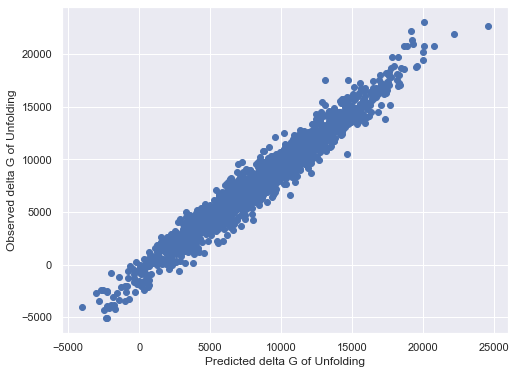

In [19]:
print(X_test.shape)
prediction = model.predict(X_test)
numpy_y_test = (y_test.to_numpy())
predictions = prediction.tolist()
predictions = [item for sublist in predictions for item in sublist]
validations = numpy_y_test.tolist()
validations = [item for sublist in validations for item in sublist]

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(predictions, validations)
correlation_coefficient = np.corrcoef(predictions,validations )
print(correlation_coefficient)

ax.set_xlabel('Predicted delta G of Unfolding')
ax.set_ylabel('Observed delta G of Unfolding')